In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import pandas as pd
from joblib import Parallel, delayed 
import random
from scipy.linalg import sqrtm
import scipy
from numpy import linalg as LA
from numpy.linalg import matrix_power
from sklearn.metrics.cluster import adjusted_rand_score
from srwr.srwr import SRWR

In [2]:
#the functions that form the block of the transition matrix 

def A_positive(G): 
    
    selected_edges = [(u,v) for u,v in G.edges if G[u][v]['weight'] == 1]
    G_pos = nx.Graph()
    G_pos.add_nodes_from(G)
    G_pos.add_edges_from(selected_edges)
    A_plus = nx.to_numpy_array(G_pos)
    return A_plus


def A_negative(G): 
    
    selected_edges = [(u,v) for u,v in G.edges if G[u][v]['weight'] == -1]
    G_neg = nx.Graph()
    G_neg.add_nodes_from(G)
    G_neg.add_edges_from(selected_edges)
    A_neg = nx.to_numpy_array(G_neg)

    return A_neg

#check if the nodes have at least one edge which is important for normalization 
def graph_checker_deg(G): 
    A_p = A_positive(G)
    A_n = A_negative(G)
    sum_of_rows = A_p.sum(axis=1) + A_n.sum(axis=1)
    return np.all(sum_of_rows)

def A_plus(G): 
    
    A_p = A_positive(G)
    A_n = A_negative(G)
    sum_of_rows = A_p.sum(axis=1) + A_n.sum(axis=1)
    normalized_aplus = A_p / sum_of_rows[:, np.newaxis]
    return normalized_aplus


def A_neg(G): 
    
    A_p = A_positive(G)
    A_n = A_negative(G)
    sum_of_rows = A_p.sum(axis=1) + A_n.sum(axis=1)
    normalized_aneg = A_n / sum_of_rows[:, np.newaxis]
    return normalized_aneg

#use this function to turn positive and negative values into +/- 1 (good for visualization, or possibly clustering)
def matrix_filter(A, thresh):
    
    n = np.shape(A)[0]
    
    new_mat = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            if A[i][j] > thresh:
                new_mat[i][j] = 1
            elif A[i][j] < thresh: 
                new_mat[i][j] = -1
    return new_mat

In [3]:
#weak balance functions

def T_weak(G, n):  
    nodes = np.shape(A_plus(G))[0]
    T = np.block([[A_plus(G), A_neg(G)], [np.zeros((nodes, nodes)), A_plus(G)]])    
    T_weak_n = matrix_power(T, n)
    return T_weak_n

#strong balance functions

def T_strong(G, n): 
    nodes = np.shape(A_plus(G))[0]
    T = np.block([[A_plus(G), A_neg(G)], [A_neg(G), A_plus(G)]]) 
    T_strong_n = matrix_power(T, n) 
    return T_strong_n

In [4]:
#instead of rescaling the vector, put dead walkers back in its original position 
#alpha = 1 is no teleportation 

#this function takes a vector after transitions, and resets lost probability to the original node 
def Rescale_Vector_ResetLost(G, vector_0, vector, alpha):
    v2 = alpha*np.matmul(vector, T_weak(G, 1)) 
    lost_prob = 1 - v2.sum(axis = 1)
    v2_new = vector_0*lost_prob[:, np.newaxis] + v2
    return v2_new
    
#here we sum over all of the vectors representing the different timesteps (length of walks)
#the output gives you the sum over all timesteps 
def Vector_Summed_Steps_ResetLost(G, vector_0, n, alpha):
    v_sum = vector_0
    v_new = vector_0
    
    for i in range(n): 
        v_new = Rescale_Vector_ResetLost(G, vector_0, v_new, alpha)
        v_sum = v_sum + v_new 
        
    return v_sum

#this would give you the vector at step n, after the probabilites have been reset at each timestep 
#you can you this to find the stationary state of the walk as n --> inf 
#the above function is essentially this function summed from n=1 to n=? as you choose 
def Vector_State_ResetLost(G, vector_0, n, alpha):
    v_old = vector_0
    v_new = Rescale_Vector_ResetLost(G, vector_0, v_old, alpha) 
    v_old = v_new
    for i in range(n): 
        v_new = Rescale_Vector_ResetLost(G, vector_0, v_old, alpha)  
        v_old = v_new
    return v_new

In [5]:
#this implements the same thing but for a strong walk (with teleportation parameter alpha)

#this function takes a vector after transitions, and resets lost probability to the original node 
def Vector_Strong_walk(G, vector_0, vector, alpha):
    v2 = alpha*np.matmul(vector, T_strong(G, 1))
    lost_prob = 1 - v2.sum(axis = 1)
    v2_new = vector_0*lost_prob[:, np.newaxis] + v2
    return v2_new
    
#here we sum over all of the vectors representing the different timesteps (length of walks)
#the output gives you the sum over all timesteps 
def Vector_Summed_Steps_Strong_walk(G, vector_0, n, alpha):
    v_sum = vector_0
    v_new = vector_0
    
    for i in range(n): 
        v_new = Vector_Strong_walk(G, vector_0, v_new, alpha)
        v_sum = v_sum + v_new 
        
    return v_sum

#this would give you the vector at step n, after the probabilites have been reset at each timestep 
#you can you this to find the stationary state of the walk as n --> inf 
#the above function is essentially this function summed from n=1 to n=? as you choose 
def Vector_State_Strong_walk(G, vector_0, n, alpha):
    v_old = vector_0
    v_new = Vector_Strong_walk(G, vector_0, v_old, alpha) 
    v_old = v_new
    for i in range(n): 
        v_new = Vector_Strong_walk(G, vector_0, v_old, alpha)  
        v_old = v_new
    return v_new

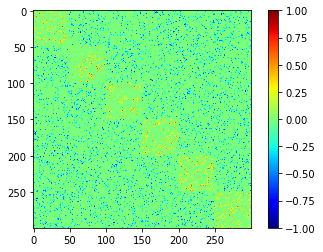

In [6]:
#create a 6 community SSBM 

#number of nodes 
N = 300

#number of communities 
k = 6

#noise parameter - inside community 
thresh_inside = 1


#noise parameter - between community 
thresh_outside = 1

#assymetry parameter 
asym = 1

#for a 6 community 
probs = np.ones((6,6))*0.05

def signed_SBM_parameters(N, k, probs, thresh_inside, thresh_outside): 
    clus_size = int(N/k)
    numbers = (np.ones(k)*clus_size).astype(int)
    #probs = (np.ones((k,k))*pval)   
    G = nx.stochastic_block_model(numbers, probs)
    co = []
    
    for i in range(k):
        co.extend(np.ones(clus_size)*(i))

    for u,v in G.edges(): 
        if co[u] == co[v]:
            test = np.random.uniform(0,1)
            if test < thresh_inside: 
           
                G.edges[u,v]["weight"] = 1
            else:
                G.edges[u,v]["weight"] = -1
        else:
            test = np.random.uniform(0,1)
            if test < thresh_outside:
                G.edges[u,v]["weight"] = -1
            else: 
                G.edges[u,v]["weight"] = 1
                
    return G, co

G, co = signed_SBM_parameters(N, k, probs, thresh_inside, thresh_outside)

#look at the adjacecy matrix of this graph
plt.imshow(nx.to_numpy_array(G),cmap=plt.cm.jet)  
plt.colorbar()

In [7]:
seed1 = np.random.randint(0, 49)
seed2 = np.random.randint(50, 99)
seed3 = np.random.randint(100, 149)
seed4 = np.random.randint(150, 199)
seed5 = np.random.randint(200, 249)
seed6 = np.random.randint(250, 299)

In [8]:
#run the wealk walk from selected seeds in the two communities, use the results to rank the other nodes and assign them to one of the communities 
#alpha = teleportation 
#itera = number of steps to use in the walk 

def weak_walk_ari_semisup(seed1, seed2, seed3, seed4, seed5, seed6, G, co, alpha, itera): 

    N = G.number_of_nodes()
    #seed starting from co = 0 node 
    vector = np.zeros((1,2*N))
    vector[0][seed1] = 1
    vector = vector / np.linalg.norm(vector)
    #Walk_Vector = Vector_Summed_Steps_ResetLost(G, vector,itera, alpha)
    Walk_Vector = Vector_State_ResetLost(G, vector,itera, alpha)
    Proximity_Vector_0 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]

    #seed starting from co = 1 node 
    vector = np.zeros((1,2*N))
    vector[0][seed2] = 1
    vector = vector / np.linalg.norm(vector)
    #Walk_Vector = Vector_Summed_Steps_ResetLost(G, vector,itera, alpha)
    Walk_Vector = Vector_State_ResetLost(G, vector,itera, alpha)
    Proximity_Vector_1 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]


    #seed starting from co = 2 node 
    vector = np.zeros((1,2*N))
    vector[0][seed3] = 1
    vector = vector / np.linalg.norm(vector)
    #Walk_Vector = Vector_Summed_Steps_ResetLost(G, vector,itera, alpha)
    Walk_Vector = Vector_State_ResetLost(G, vector,itera, alpha)
    Proximity_Vector_2 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]
    
    #seed starting from co = 2 node 
    vector = np.zeros((1,2*N))
    vector[0][seed4] = 1
    vector = vector / np.linalg.norm(vector)
    #Walk_Vector = Vector_Summed_Steps_ResetLost(G, vector,itera, alpha)
    Walk_Vector = Vector_State_ResetLost(G, vector,itera, alpha)
    Proximity_Vector_3 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]
    
    
    #seed starting from co = 2 node 
    vector = np.zeros((1,2*N))
    vector[0][seed5] = 1
    vector = vector / np.linalg.norm(vector)
    #Walk_Vector = Vector_Summed_Steps_ResetLost(G, vector,itera, alpha)
    Walk_Vector = Vector_State_ResetLost(G, vector,itera, alpha)
    Proximity_Vector_4 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]
    
    
    #seed starting from co = 2 node 
    vector = np.zeros((1,2*N))
    vector[0][seed6] = 1
    vector = vector / np.linalg.norm(vector)
    #Walk_Vector = Vector_Summed_Steps_ResetLost(G, vector,itera, alpha)
    Walk_Vector = Vector_State_ResetLost(G, vector,itera, alpha)
    Proximity_Vector_5 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]


#sort all the nodes based on where they appear in the rankings from the seeds
    a_0 = list(np.argsort(Proximity_Vector_0)[0])
    a_1 = list(np.argsort(Proximity_Vector_1)[0])
    a_2 = list(np.argsort(Proximity_Vector_2)[0])
    a_3 = list(np.argsort(Proximity_Vector_3)[0])
    a_4 = list(np.argsort(Proximity_Vector_4)[0])
    a_5 = list(np.argsort(Proximity_Vector_5)[0])


#assign clusters based on in which ranking they appear the highest 

    clus_assign = []

    for i in range(N): 
        ind_0 = a_0.index(i)
        ind_1 = a_1.index(i)
        ind_2 = a_2.index(i)
        ind_3 = a_3.index(i)
        ind_4 = a_4.index(i)
        ind_5 = a_5.index(i)
    
        list_ind = [ind_0, ind_1, ind_2, ind_3, ind_4, ind_5]
        #print(list_ind)
        min_value = max(list_ind) 
        min_index = list_ind.index(min_value)
        clus_assign.append(min_index)

    return adjusted_rand_score(co, clus_assign)

In [ ]:
alpha = 1
itera = 100
weak_walk_ari_semisup(seed1, seed2, seed3, seed4, seed5, seed6, G, co, alpha, itera)

In [ ]:
#same but for strong walk 
#instead of choosing alpha = 1, we do a parameter sweep over all choices and select the best one 

#try with the strong walk 

def strong_walk_ari_semisup(seed1, seed2, seed3,  seed4, seed5, seed6, G, co, itera): 

    N = G.number_of_nodes()
    
    ari_stored = []
    
    for alpha in np.arange(0, 1.1, 0.1):

        #seed starting from co = 0 node 
        vector = np.zeros((1,2*N))
        vector[0][seed1] = 1
        vector = vector / np.linalg.norm(vector)
        #Walk_Vector = Vector_Summed_Steps_Strong_walk(G, vector, itera, alpha)
        Walk_Vector = Vector_State_Strong_walk(G, vector, itera, alpha)
        Proximity_Vector_0 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]


        #seed starting from co = 1 node 
        vector = np.zeros((1,2*N))
        vector[0][seed2] = 1
        vector = vector / np.linalg.norm(vector)
        #Walk_Vector = Vector_Summed_Steps_Strong_walk(G, vector, itera, alpha)
        Walk_Vector = Vector_State_Strong_walk(G, vector, itera, alpha)
        Proximity_Vector_1 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]


        #seed starting from co = 2 node 
        vector = np.zeros((1,2*N))
        vector[0][seed3] = 1
        vector = vector / np.linalg.norm(vector)
        #Walk_Vector = Vector_Summed_Steps_Strong_walk(G, vector, itera, alpha)
        Walk_Vector = Vector_State_Strong_walk(G, vector, itera, alpha)
        Proximity_Vector_2 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]

            #seed starting from co = 2 node 
        vector = np.zeros((1,2*N))
        vector[0][seed4] = 1
        vector = vector / np.linalg.norm(vector)
        #Walk_Vector = Vector_Summed_Steps_Strong_walk(G, vector, itera, alpha)
        Walk_Vector = Vector_State_Strong_walk(G, vector, itera, alpha)
        Proximity_Vector_3 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]

            #seed starting from co = 2 node 
        vector = np.zeros((1,2*N))
        vector[0][seed5] = 1
        vector = vector / np.linalg.norm(vector)
        #Walk_Vector = Vector_Summed_Steps_Strong_walk(G, vector, itera, alpha)
        Walk_Vector = Vector_State_Strong_walk(G, vector, itera, alpha)
        Proximity_Vector_4 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]

            #seed starting from co = 2 node 
        vector = np.zeros((1,2*N))
        vector[0][seed6] = 1
        vector = vector / np.linalg.norm(vector)
        #Walk_Vector = Vector_Summed_Steps_Strong_walk(G, vector, itera, alpha)
        Walk_Vector = Vector_State_Strong_walk(G, vector, itera, alpha)
        Proximity_Vector_5 = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]


        #sort all the nodes based on where they appear in the rankings from the seeds
        a_0 = list(np.argsort(Proximity_Vector_0)[0])
        a_1 = list(np.argsort(Proximity_Vector_1)[0])
        a_2 = list(np.argsort(Proximity_Vector_2)[0])
        a_3 = list(np.argsort(Proximity_Vector_3)[0])
        a_4 = list(np.argsort(Proximity_Vector_4)[0])
        a_5 = list(np.argsort(Proximity_Vector_5)[0])


    #assign clusters based on in which ranking they appear the highest 

        clus_assign = []

        for i in range(N): 
            ind_0 = a_0.index(i)
            ind_1 = a_1.index(i)
            ind_2 = a_2.index(i)
            ind_3 = a_3.index(i)
            ind_4 = a_4.index(i)
            ind_5 = a_5.index(i)

            list_ind = [ind_0, ind_1, ind_2, ind_3, ind_4, ind_5]
            min_value = max(list_ind) 
            min_index = list_ind.index(min_value)
            clus_assign.append(min_index)

        ari_stored.append(adjusted_rand_score(co, clus_assign))
    
    max_ari = max(ari_stored)
    return adjusted_rand_score(co, clus_assign)

In [9]:
itera = 100
strong_walk_ari_semisup(seed1, seed2, seed3,  seed4, seed5, seed6, G, co, itera)

NameError: name 'strong_walk_ari_semisup' is not defined

In [ ]:
#if you have the SRWR implemented, use this to run that 
#sweep over all parameters (c, beta, gamma)

def SRWR_ari_semisup(seed1, seed2, seed3, seed4, seed5, seed6, G, co, max_iters):
    
    
    H = G.to_directed()

    with open('graph_input.txt', 'w') as f:
        for line in nx.generate_edgelist(H, data=["weight"]):
            f.write(line)
            f.write('\n')
            
    srwr = SRWR()
    srwr.read_graph('graph_input.txt') # read graph from input_path
    srwr.normalize() # do semi row-normalization
    
    #Error tolerance for power iteration
    epsilon = 1e-12

    handles_deadend = True
    
    ari_stored = []
    
    for c in np.arange(0, 1.1, 0.1):
    
        for beta in np.arange(0, 1.1, 0.1): 
        #for beta in [0.5]:
            for gamma in np.arange(0, 1.1, 0.1): 
            #for gamma in [0.9]:

                rd_0, rp_0, rn_0, residuals_0 = srwr.query(seed1, c, epsilon, beta, gamma, max_iters, handles_deadend, verbose = False) 

                rd_1, rp_1, rn_1, residuals_1 = srwr.query(seed2, c, epsilon, beta, gamma, max_iters, handles_deadend, verbose = False) 

                rd_2, rp_2, rn_2, residuals_2 = srwr.query(seed3, c, epsilon, beta, gamma, max_iters, handles_deadend, verbose = False)

                rd_3, rp_3, rn_3, residuals_3 = srwr.query(seed4, c, epsilon, beta, gamma, max_iters, handles_deadend, verbose = False)
                rd_4, rp_4, rn_4, residuals_4 = srwr.query(seed5, c, epsilon, beta, gamma, max_iters, handles_deadend, verbose = False)
                rd_5, rp_5, rn_5, residuals_5 = srwr.query(seed6, c, epsilon, beta, gamma, max_iters, handles_deadend, verbose = False)


                a_0 = list(np.argsort(rd_0, axis = 0).flatten())
                a_1 = list(np.argsort(rd_1, axis = 0).flatten())
                a_2 = list(np.argsort(rd_2, axis = 0).flatten())
                a_3 = list(np.argsort(rd_3, axis = 0).flatten())
                a_4 = list(np.argsort(rd_4, axis = 0).flatten())
                a_5 = list(np.argsort(rd_5, axis = 0).flatten())

                clus_assign = []

                for i in range(N): 
                    ind_0 = a_0.index(i)
                    ind_1 = a_1.index(i)
                    ind_2 = a_2.index(i)
                    ind_3 = a_3.index(i)
                    ind_4 = a_4.index(i)
                    ind_5 = a_5.index(i)

                    list_ind = [ind_0, ind_1, ind_2, ind_3, ind_4, ind_5]
                    min_value = max(list_ind) 
                    min_index = list_ind.index(min_value)
                    clus_assign.append(min_index)

                ari_stored.append(adjusted_rand_score(co, clus_assign))
            
    max_ari = max(ari_stored)
        
    return max_ari

In [ ]:
max_iters = 500
SRWR_ari_semisup(seed1, seed2, seed3, seed4, seed5, seed6, G, co, max_iters)

In [ ]:
#use this to run experiments comparing the walk, parallelized 
from joblib import Parallel, delayed

def walk_test_func(thresh, iteraindex): 
    print(thresh, iteraindex)
    #number of nodes 
    N = 300
    #number of communities 
    k = 6
    iteras = 1 
    #for a 6 community 
    probs = np.ones((6,6))*0.05

    graph_check = False
    while graph_check == False: 
        G, co = signed_SBM_parameters(N, k, probs, 1, thresh)
        graph_check = graph_checker_deg(G)
        
    seed1 = np.random.randint(0, 49)
    seed2 = np.random.randint(50, 99)
    seed3 = np.random.randint(100, 149)
    seed4 = np.random.randint(150, 199)
    seed5 = np.random.randint(200, 249)
    seed6 = np.random.randint(250, 299)
    
    alpha = 1
    itera = 300
    weak_walk_ari= weak_walk_ari_semisup(seed1, seed2, seed3, seed4, seed5, seed6, G, co, alpha, itera)
            
    itera = 300
    strong_walk_ari = strong_walk_ari_semisup(seed1, seed2, seed3, seed4, seed5, seed6, G, co, itera)
    
    max_iters = 300
    srwr_ari = SRWR_ari_semisup(seed1, seed2, seed3, seed4, seed5, seed6, G, co, max_iters)
    
    return [thresh, weak_walk_ari, strong_walk_ari, srwr_ari]

In [ ]:
%%time

params = np.arange(0.6 ,1.05, 0.05)

results = Parallel(n_jobs=6)\
    (delayed(walk_test_func)(to, i) for to in params for i in range(10))

In [ ]:
my_df = pd.DataFrame(results)
#my_df.to_csv('ww_tele_sweep_6com_noise_outside_state.csv', index=False, header=False)
data = my_df.rename(columns={0: 'xval', 1: 'yval_weak', 2: 'yval_strong', 3: 'yval_srwr'}) 

import matplotlib.style as style

mean_weak = data.groupby('xval', as_index=False, sort=True)['yval_weak'].mean()
std_weak = data.groupby('xval', as_index=False, sort=True)['yval_weak'].std()

mean_strong = data.groupby('xval', as_index=False, sort=True)['yval_strong'].mean()
std_strong = data.groupby('xval', as_index=False, sort=True)['yval_strong'].std()

mean_srwr = data.groupby('xval', as_index=False, sort=True)['yval_srwr'].mean()
std_srwr = data.groupby('xval', as_index=False, sort=True)['yval_srwr'].std()

style.use('seaborn-poster')
plt.style.use('ggplot')
plt.figure(figsize =(15,10))

vals = mean_weak['xval']
m_rep = mean_weak['yval_weak']
std_rep = std_weak['yval_weak']
plt.plot(vals, m_rep, color= 'darkblue', label = 'Weak Walk')
plt.fill_between(vals, m_rep-std_rep, m_rep+std_rep, alpha = 0.2, color= 'darkblue')

vals = mean_strong['xval']
m_rep = mean_strong['yval_strong']
std_rep = std_strong['yval_strong']
plt.plot(vals, m_rep, color= 'darkgreen', label = 'Strong Walk')
plt.fill_between(vals, m_rep-std_rep, m_rep+std_rep, alpha = 0.2, color= 'darkgreen')

vals = mean_srwr['xval']
m_rep = mean_srwr['yval_srwr']
std_rep = std_srwr['yval_srwr']
plt.plot(vals, m_rep, color= 'darkred', label = 'SRWR')
plt.fill_between(vals, m_rep-std_rep, m_rep+std_rep, alpha = 0.2, color= 'darkred')

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.title("State Vector 6 Community", fontsize = 30)
plt.xlabel("Noise Probability (Whole Graph)", fontsize = 30)
plt.ylabel("Semisupervised ARI)", fontsize = 30)
plt.legend(fontsize = 30)

plt.show()